In [99]:
## Importing Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, AncillaRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import math

In [112]:
## Settings
d = 1 # of dimensions
M = 2 # of registers (rough estimate for M is the number of particles in the final state, but M should be set so that p_success can be maximized)
n = 1 # of particles in the initial state
N_abs = 3 # of modes for momenta
m = 1 # mass of particles of projectile
tau_0 = 1 # time for free field
M_step = 100
tau_I = 1 # time for interaction time

N_s = 2 ** (N_abs + 1) # size of the lattice per one dimension
V = N_s ** d # volume
N = N_abs * d + d + 1 # of qubits per one particle (magnitude of momentum + sign + occupation)
s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.
delta_0 = tau_0 /  M_step

In [113]:
d

1

1


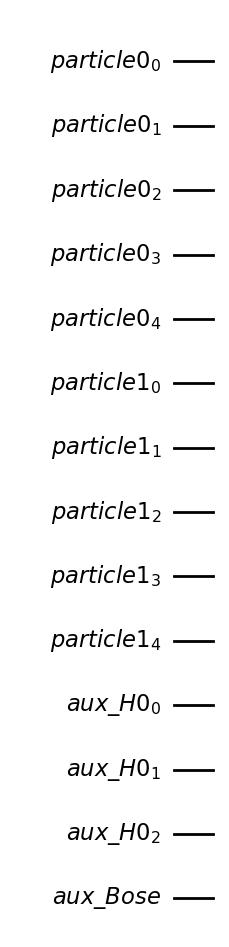

In [115]:
def init(M, N_abs, d): # initialize circuit
    N = N_abs * d + d + 1
    print(d)
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister(N, name = f'particle{i}'))
    ancilla_register_h0 = AncillaRegister((N_abs + math.log2(n)) * d, name = f'aux_H0') # aux registers for free Hamiltonian
    ancilla_register_symm = AncillaRegister(s, name = f'aux_Bose') # aux registers for Bose symmetrization
    circuit = QuantumCircuit(*particle_registers, ancilla_register_h0, ancilla_register_symm)
    return circuit, particle_registers, ancilla_register_h0, ancilla_register_symm

circuit, particle_regs, anc_reg_h0, anc_reg_symm = init(M, N_abs, d)
circuit.draw('mpl')

In [18]:
#### examples of operation ####

# particle_registers[0:2] # QuantumRegisterのリスト [QuantumRegister(4, 'particle0'), QuantumRegister(4, 'particle1')]
# particle_registers[:2][1] # QuantumRegister # リストの第１成分 QuantumRegister(4, 'particle1')
# particle_registers[:2][1][0:2] # Qubitのリスト
# particle_registers[:2][1][0] # Qubit # Qubit(QuantumRegister(4, 'particle1'), 0)

## operate x gate to one certain qubit
# circuit.x(((L + 1) * d + 1) * M)
# circuit.h(particle_registers[0])
# circuit.h(particle_registers[0])
# circuit.h(ancilla_register_h0[1])

## operate x gate to one certain particle register
# circuit.x(particle_registers[0])

## operate x gate to all qubits
# for i in range(M):
#     circuit.x(particle_registers[i])

# circuit.draw('mpl') # 1つのparticleに対して下位 L* d ビットが運動量の大きさ、次のdビットが符号、最後1ビットがoccupancy

1


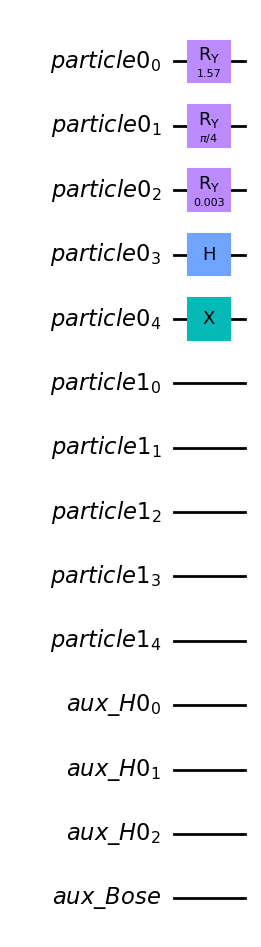

In [117]:
#### A. Initial State Preparation ####
circuit, particle_regs, anc_reg_h0, anc_reg_symm = init(M, N_abs, d)
## 初期状態において, 粒子がある量子レジスタのインデックスのリストを用意する
## 第0量子レジスタに粒子があると仮定
# reg_list = [1]
# ボース対称化するので, 第0量子レジスタから順に第n(=入射粒子数)量子レジスタまで粒子を詰めていく

## Gaussian wave packet で局在化
for ireg in range(n):
    circuit.x(particle_regs[ireg][N_abs * d + d])
    circuit.h(particle_regs[ireg][N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        eps = 0.0015 # pがガウシアンになるように調整する必要あり
        theta_lin = np.pi / 4 - eps + ((2 * eps - np.pi / 4) / (N_abs - 1)) * (iqubit % N_abs) # 論文のAppendixのtheta_linear
        circuit.ry(2 * theta_lin, particle_regs[ireg][iqubit])
circuit.draw('mpl')

1


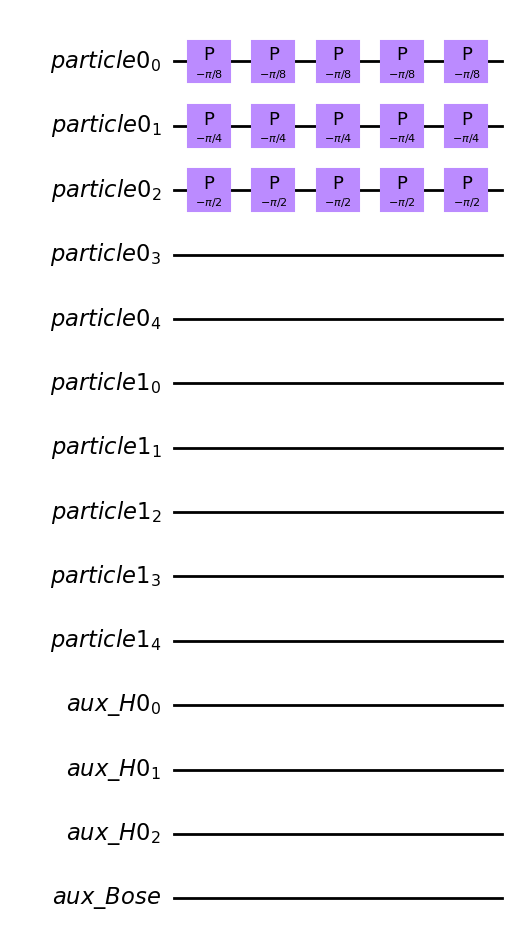

In [118]:
circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm = init(M, N_abs, d)
## 波束の位置空間の重心 xbar を並進移動させる
pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 5 # 第0量子レジスタの第0次元に存在する粒子を5マス移動

# check whether constraint (並進移動させるマスが N_s 以内か) is satisfied
for icolumn in range(len(pos_trans_mat)):
    for irow in range(len(pos_trans_mat[0])):
        if pos_trans_mat[icolumn][irow] > N_s: # N_s - 1 かも？
            print('Constraint Error!!')

for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        for itrans in range(int(pos_trans_mat[ireg][idim])): # ここ、分ける必要ないのでは？ # 無限小並進演算子をtrans[ireg][idim]回作用させる
            for iqubit in range(N_abs * d): # 量子レジスタ内のiqubit番目の量子ビットを考える
                if pos_trans_mat[ireg][idim] > 0:
                    circuit.p((-2. * np.pi * (2. ** iqubit)) / N_s, particle_regs[ireg][iqubit])
                    # circuit.p((-2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき
                elif pos_trans_mat[ireg][idim] < 0:
                    circuit.p((2. * np.pi * (2. ** iqubit)) / N_s, particle_regs[ireg][iqubit])
                    # circuit.p((2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき

circuit.draw('mpl')

1


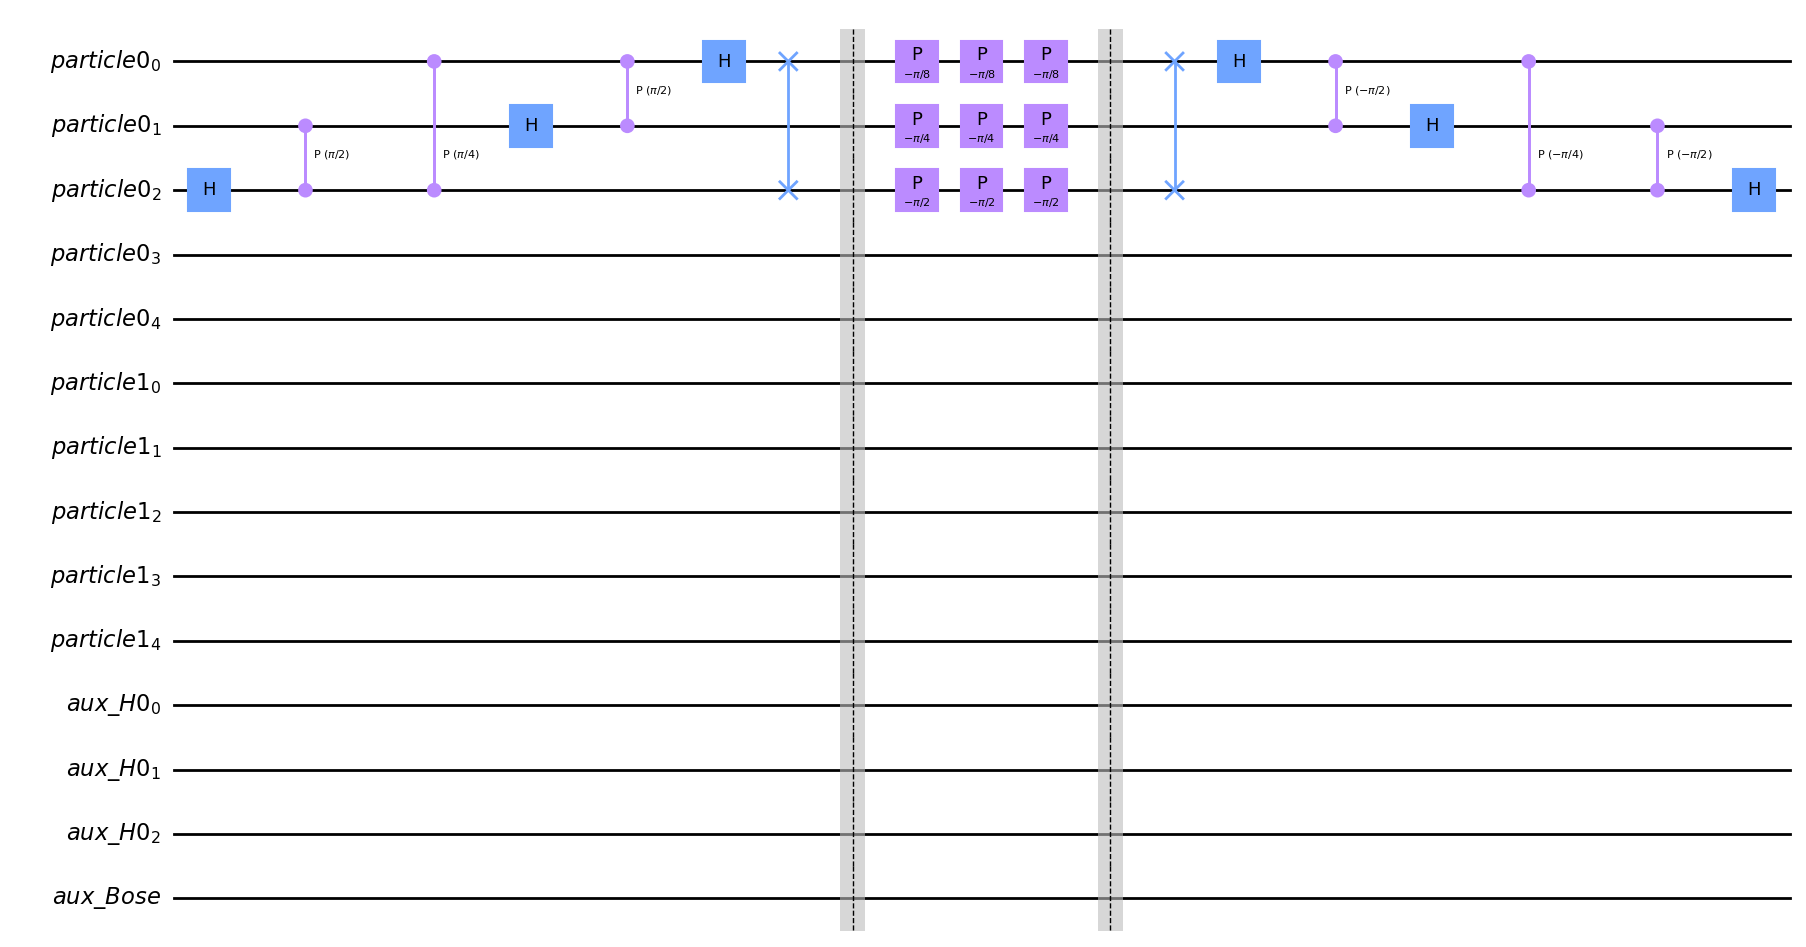

In [125]:
circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm = init(M, N_abs, d)
## 上のセルと同様に, 運動量空間の重心 pbar も並進移動させる
## QFTを使うだけでやり方は全く同じ（はず）

## 波束の運動量空間の重心 pbar を並進移動させる
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 3 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心を3マス移動

# QFT
for ireg in range(n):
    for idim in range(d):
        for iqubit in range(N_abs - 1, -1, -1):
            circuit.h(particle_regs[ireg][iqubit])
            for ictrl in range(iqubit - 1, -1, -1):
                power = ictrl - iqubit - 1 + N_abs
                phi = (2 ** power) * 2. * np.pi / (2 ** N_abs)
                circuit.cp(phi, particle_regs[ireg][ictrl], particle_regs[ireg][iqubit])
            # circuit.barrier()
        for iswap in range(N_abs // 2):
            circuit.swap(particle_regs[ireg][iswap], particle_regs[ireg][N_abs - 1 - iswap])

# momentum translation
circuit.barrier()
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        for itrans in range(int(mom_trans_mat[ireg][idim])): # ここ、分ける必要ないのでは？ # 無限小並進演算子をtrans[ireg][idim]回作用させる
            for iqubit in range(N_abs): # 量子レジスタ内のiqubit番目の量子ビットを考える
                if mom_trans_mat[ireg][idim] > 0:
                    circuit.p((-2. * np.pi * (2. ** iqubit)) / N_s, particle_regs[ireg][iqubit])
                    # circuit.p((-2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき
                elif mom_trans_mat[ireg][idim] < 0:
                    circuit.p((2. * np.pi * (2. ** iqubit)) / N_s, particle_regs[ireg][iqubit])
                    # circuit.p((2. * np.pi * (2. ** iqubit) * mom_trans_mat[ireg][idim]) / N_s, particle_regs[ireg][iqubit]) # 分けなかったとき

# 逆QFT
circuit.barrier()
for ireg in range(n):
    for idim in range(d):
        for iswap in range(N_abs // 2):
            circuit.swap(particle_regs[ireg][iswap], particle_regs[ireg][N_abs - 1 - iswap])
        # circuit.barrier()
        for iqubit in range(N_abs):
            for ictrl in range(iqubit):
                power = ictrl - iqubit - 1 + N_abs
                phi = (2 ** power) * 2. * np.pi / (2 ** N_abs)
                circuit.cp(- phi, particle_regs[ireg][ictrl], particle_regs[ireg][iqubit])
            circuit.h(particle_regs[ireg][iqubit])
            # circuit.barrier()

circuit.draw('mpl')

1


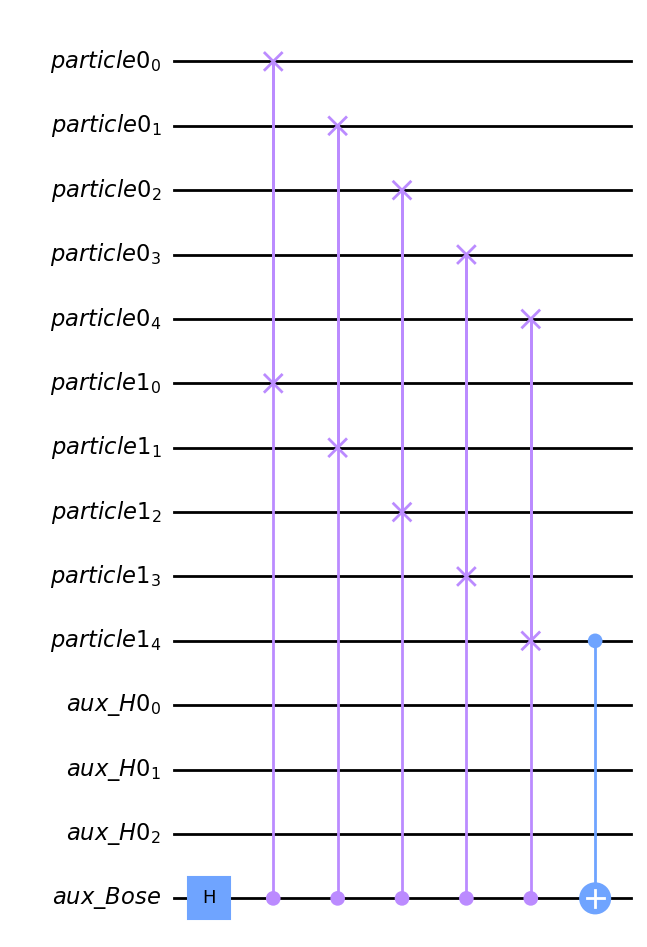

In [120]:
circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm = init(M, N_abs, d)
## Bose symmetrization
# n, Mに応じて改訂する必要あり
circuit.h(anc_reg_symm[0])
for ireg in range(M):
    for jreg in range(M):
        for iqubit in range(N):
            if ireg > jreg:
                circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
# circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

circuit.cx(particle_regs[1][N - 1], anc_reg_symm)

circuit.draw('mpl')

1


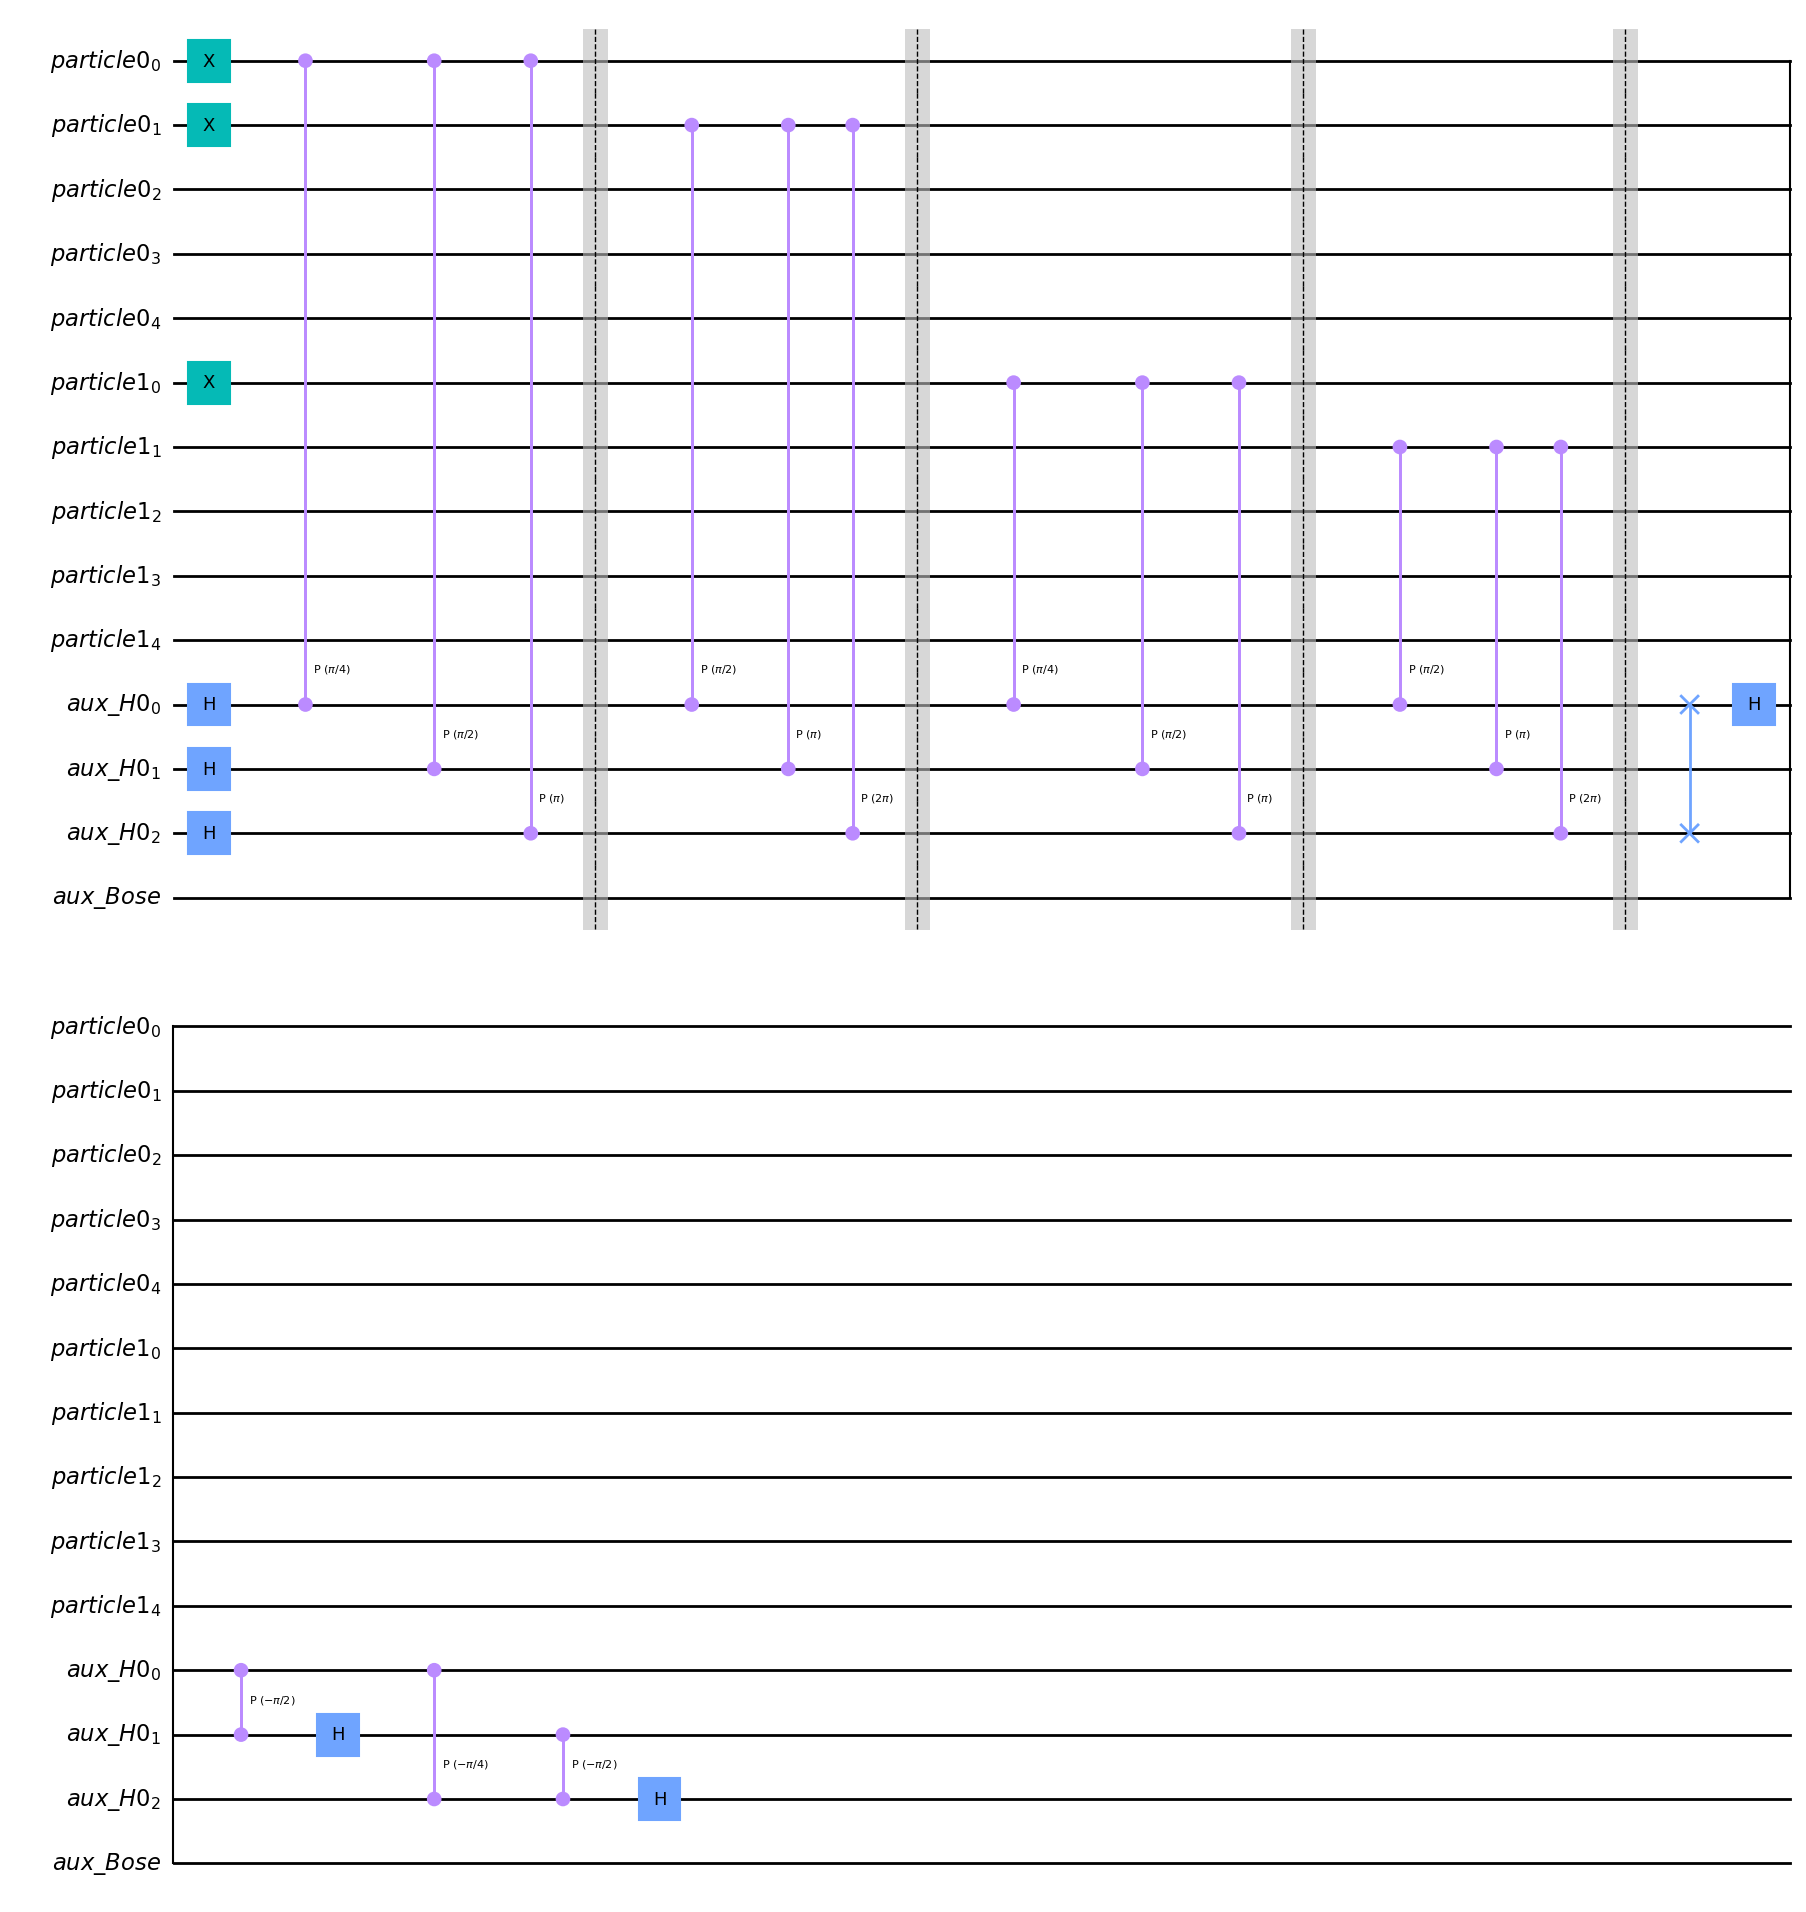

In [123]:
#### B. Time Evolution ####
## Free Hamiltonian ##
# (全体位相がかかるだけなので要らないのでは？→ガウス型波束は時間発展ともに広がるので必要)
# まず、フーリエ変換を用いて足し算を実装→それを元にS^phiをかけていく

# circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm = init(M, N_abs, d)
circuit.x(particle_regs[0][0])
circuit.x(particle_regs[0][1])
circuit.x(particle_regs[1][0])

l0 = anc_reg_h0.size
dphi = 2 * np.pi / (2 ** anc_reg_h0.size)

circuit.h(anc_reg_h0) # equal superposition
# addition
for reg_ctrl in particle_regs:
    for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d - 1]):
        for itarg, qtarg in enumerate(anc_reg_h0):
            circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
        circuit.barrier()

# inverse QFT
for iswap in range(l0 // 2):
    circuit.swap(anc_reg_h0[iswap], anc_reg_h0[l0 - 1 - iswap])
for iqubit in range(l0):
    for ictrl in range(iqubit):
        power = ictrl - iqubit - 1 + N_abs
        phi = (2 ** power) * 2. * np.pi / (2 ** N_abs)
        circuit.cp(- phi, anc_reg_h0[ictrl], anc_reg_h0[iqubit])
    circuit.h(anc_reg_h0[iqubit])

circuit.draw('mpl')

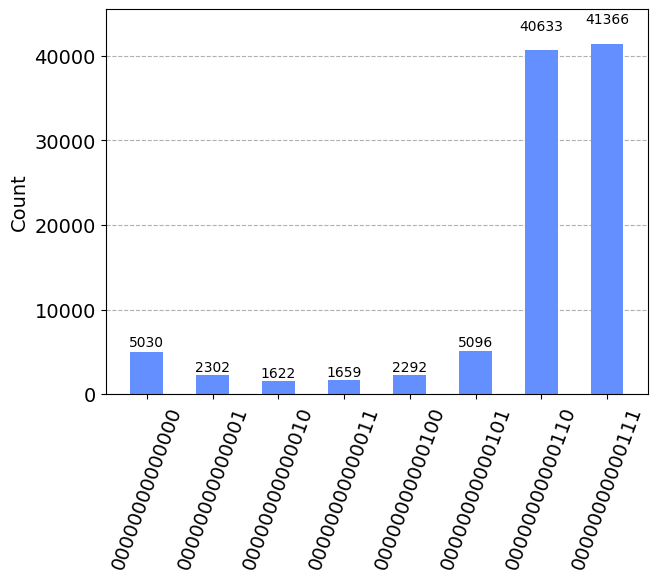

In [126]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=100000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)